In [1]:
import cv2
import os
import time
import datetime
import random
import numpy as np
from matplotlib import pyplot as plt
import shutil
import tensorflow as tf
from PIL import Image
import gc
import json
import pickle

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
def load_image_paths(base_path):
    """
    Load all image paths from the dataset.

    Args:
        base_path (str): The root directory where the images are stored.
    
    Returns:
        dict: A dictionary where each key is a person's directory, and the value is a list of image paths for that person.
    """
    image_paths = {}
    
    # Loop through each directory (person)
    for person_dir in os.listdir(base_path):
        person_path = os.path.join(base_path, person_dir)
        
        if os.path.isdir(person_path):
            # Get all image files in the directory
            images = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:  # If the person has images
                image_paths[person_dir] = images
    
    return image_paths

In [4]:
def save_progress(progress_file, progress_data):
    """
    Save the current progress of pair generation to a JSON file.
    
    Args:
        progress_file (str): The file path to save the progress data.
        progress_data (dict): The dictionary containing the current progress data.
        
    Description:
        This function writes the progress (number of positive and negative pairs generated)
        to a file in JSON format. This helps in resuming the generation process from where
        it left off in case of a notebook restart.
    """
    with open(progress_file, 'w') as f:
        json.dump(progress_data, f)

In [5]:
def load_progress(progress_file):
    """
    Load the progress information from a file.
    
    Args:
        progress_file (str): The file path to load progress from.
    
    Returns:
        dict: Dictionary containing the current progress data, or None if no progress file exists.
        
    Description:
        This function reads the progress information from a JSON file and returns it. 
        If the file does not exist, it returns None, indicating no saved progress.
    """
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            return json.load(f)
    return None

In [6]:
def save_pairs_to_disk(pairs, file_path):
    """
    Save the generated image pairs to a disk using pickle.
    
    Args:
        pairs (list): The list of image pairs (either positive or negative) to save.
        file_path (str): The file path to save the pairs (pickle file).
        
    Description:
        This function serializes the pairs using pickle and saves them to a file. This 
        allows us to store large amounts of data (pairs) efficiently, which can be loaded 
        later if needed.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(pairs, f)

In [7]:
def generate_positive_pairs(image_paths, batch_size):
    """
    Generate positive pairs (same person) from the dataset.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        batch_size (int): The number of positive pairs to generate in the current batch.
    
    Returns:
        list: A list of positive pairs (tuples of image paths).
        
    Description:
        This function generates positive pairs by randomly selecting a person and then 
        selecting two distinct images of that person. It continues until the specified 
        batch size of positive pairs is reached.
    """
    positive_pairs = []
    directories = list(image_paths.keys())

    while len(positive_pairs) < batch_size:
        person = random.choice(directories)
        images = image_paths[person]

        # Ensure distinct pairs by using different image indices
        for i in range(len(images)):
            for j in range(i + 1, len(images)):  # i != j to create distinct pairs
                positive_pairs.append((images[i], images[j]))
                if len(positive_pairs) >= batch_size:
                    break
            if len(positive_pairs) >= batch_size:
                break

    return positive_pairs

In [8]:
def generate_negative_pairs(image_paths, batch_size):
    """
    Generate negative pairs (different people) from the dataset, ensuring no duplicate pairs.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        batch_size (int): The number of negative pairs to generate in the current batch.
    
    Returns:
        list: A list of negative pairs (tuples of image paths).
        
    Description:
        This function generates negative pairs by randomly selecting two different people 
        and pairing one image from each. It ensures no duplicate pairs are generated.
    """
    negative_pairs = set()  # Use a set to track unique pairs
    directories = list(image_paths.keys())

    while len(negative_pairs) < batch_size:
        # Select two directories (people)
        person1, person2 = random.sample(directories, 2)

        # If both people are the same, skip to the next iteration
        if person1 == person2:
            continue

        # Select random images from each person
        image1 = random.choice(image_paths[person1])
        image2 = random.choice(image_paths[person2])

        # Create a unique identifier for the negative pair
        pair = tuple(sorted([image1, image2]))  # Sorting ensures (image1, image2) and (image2, image1) are the same

        # Only add the pair if it's not already in the set
        if pair not in negative_pairs:
            negative_pairs.add(pair)

    # Convert the set of pairs back to a list for returning
    return list(negative_pairs)


In [9]:
def generate_pairs_in_batches(image_paths, target_positive_pairs, target_negative_pairs,batch_size, progress_file,positive_file, negative_file):
    """
    Generate positive and negative image pairs in batches and save them after each batch.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        target_positive_pairs (int): The total number of positive pairs to generate.
        target_negative_pairs (int): The total number of negative pairs to generate.
        batch_size (int): The number of pairs to generate per batch.
        progress_file (str): The file path to save/load progress.
        positive_file (str): The file path to save/load positive pairs.
        negative_file (str): The file path to save/load negative pairs.
    
    Returns:
        tuple: The total number of positive and negative pairs generated.
        
    Description:
        This function coordinates the generation of positive and negative pairs in batches.
        It loads any saved progress and continues from where it left off. It generates pairs 
        in batches, saves them to disk, and updates the progress after each batch.
    """
    # Load progress if it exists
    progress = load_progress(progress_file)
    if progress:
        positive_count = progress['positive_count']
        negative_count = progress['negative_count']
    else:
        positive_count = 0
        negative_count = 0

    # Load previously saved pairs or initialize empty lists
    if os.path.exists(positive_file):
        with open(positive_file, 'rb') as f:
            positive_pairs = pickle.load(f)
    else:
        positive_pairs = []

    if os.path.exists(negative_file):
        with open(negative_file, 'rb') as f:
            negative_pairs = pickle.load(f)
    else:
        negative_pairs = []

    # Generate pairs in batches until the target count is reached
    while positive_count < target_positive_pairs or negative_count < target_negative_pairs:
        # Generate a batch of positive and negative pairs
        batch_positive_pairs = generate_positive_pairs(image_paths, batch_size)
        batch_negative_pairs = generate_negative_pairs(image_paths, batch_size)

        # Update the count of generated pairs
        positive_count += len(batch_positive_pairs)
        negative_count += len(batch_negative_pairs)

        # Add the generated pairs to the main list
        positive_pairs.extend(batch_positive_pairs)
        negative_pairs.extend(batch_negative_pairs)

        # Save the updated pairs to disk after each batch
        save_pairs_to_disk(positive_pairs, positive_file)
        save_pairs_to_disk(negative_pairs, negative_file)

        # Save progress after each batch
        progress_data = {
            'positive_count': positive_count,
            'negative_count': negative_count
        }
        save_progress(progress_file, progress_data)

        # Stop when the target number of pairs is reached
        if positive_count >= target_positive_pairs and negative_count >= target_negative_pairs:
            break

    return positive_count, negative_count


In [10]:
# Load image paths from the dataset
base_path = '/kaggle/input/casia-webface/casia-webface'  # Replace with your dataset path
image_paths = load_image_paths(base_path)

# Define the target number of pairs
target_positive_pairs = 10000
target_negative_pairs = 10000
batch_size = 1000  # Number of pairs to generate per batch

# File paths
progress_file = '/kaggle/working/progress_10k.json'
positive_file = '/kaggle/working/positive_pairs_10k.pkl'
negative_file = '/kaggle/working/negative_pairs_10k.pkl'

# Check if pickle files already exist
if os.path.exists(positive_file) or os.path.exists(negative_file):
    print(f"Pairs already generated !! . Exited")
    
else:
    # Generate pairs in batches
    positive_count, negative_count = generate_pairs_in_batches(
        image_paths, 
        target_positive_pairs, 
        target_negative_pairs, 
        batch_size=batch_size,
        progress_file=progress_file,
        positive_file=positive_file,
        negative_file=negative_file
    )

    # Output the number of pairs generated
    print(f"Total positive pairs generated: {positive_count}")
    print(f"Total negative pairs generated: {negative_count}")

Total positive pairs generated: 10000
Total negative pairs generated: 10000


# visualization

In [11]:
def load_pairs_from_pickle(pickle_file_path):
    """
    Load pairs of images from a pickle file.
    
    Args:
        pickle_file_path (str): Path to the pickle file containing pairs.
        
    Returns:
        list: A list of pairs, where each pair is a tuple of two image file paths.
    """
    with open(pickle_file_path, 'rb') as file:
        pairs = pickle.load(file)
    return pairs

In [12]:
def get_random_pair(pairs):
    """
    Randomly select a pair from the list of pairs.
    
    Args:
        pairs (list): List of pairs, where each pair is a tuple of two image file paths.
        
    Returns:
        tuple: A randomly selected pair of image paths.
    """
    return random.choice(pairs)

In [13]:
def visualize_pair(pair, is_negative=False):
    """
    Visualize a single pair of images along with their directory and image names as labels on the images.
    The label format will differ based on whether the pair is positive or negative.

    Args:
        pair (tuple): A tuple containing two image paths.
        is_negative (bool): A flag indicating whether the pair is negative. Default is False (positive pair).
    """
    # Load images
    image1 = Image.open(pair[0])
    image2 = Image.open(pair[1])

    # Extract directory and image names
    dir1, filename1 = os.path.split(pair[0])
    dir2, filename2 = os.path.split(pair[1])

    # Display the images with directory/image name as labels
    plt.figure(figsize=(8, 4))
    
    # Image 1
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title(f"Image 1")
    # Label with directory and image name
    label1 = f"{os.path.basename(dir1)}/{filename1}"
    plt.text(0, 10, label1, color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))
    plt.axis('off')

    # Image 2
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title(f"Image 2")
    # Label with directory and image name
    label2 = f"{os.path.basename(dir2)}/{filename2}"
    plt.text(0, 10, label2, color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))
    plt.axis('off')

    # Add title for positive or negative pair
    if is_negative:
        plt.suptitle("Negative Pair", fontsize=16, color='red', y=0.95)
    else:
        plt.suptitle("Positive Pair", fontsize=16, color='green', y=0.95)

    plt.show()

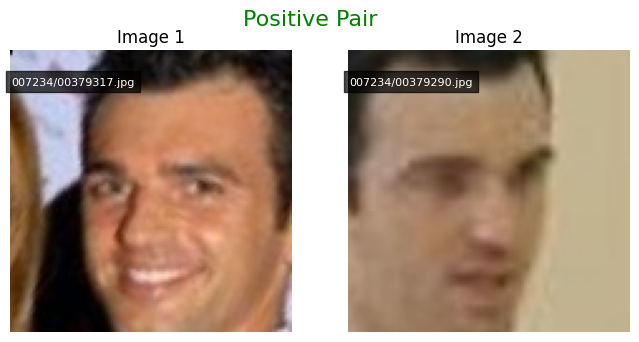

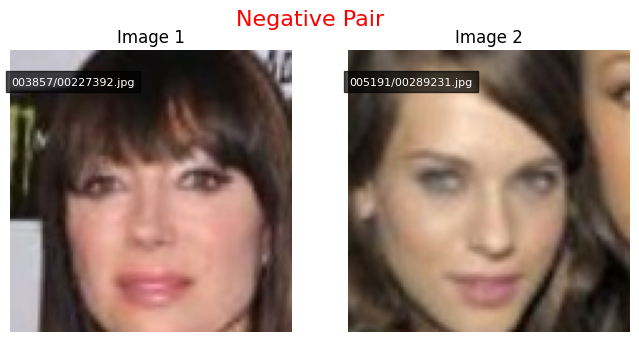

In [14]:
# Define paths to pickle files
positive_pickle = '/kaggle/working/positive_pairs_10k.pkl'  # Path to positive pairs pickle file
negative_pickle = '/kaggle/working/negative_pairs_10k.pkl'  # Path to negative pairs pickle file

# Load pairs from pickle files
positive_pairs = load_pairs_from_pickle(positive_pickle)
negative_pairs = load_pairs_from_pickle(negative_pickle)

# Randomly select a pair from positive pairs
random_positive_pair = get_random_pair(positive_pairs)
visualize_pair(random_positive_pair, is_negative=False)

# Randomly select a pair from negative pairs
random_negative_pair = get_random_pair(negative_pairs)
visualize_pair(random_negative_pair, is_negative=True)


# validation

In [15]:
def validate_pair(pair_type, pair):
    """
    Validate the given pair based on its type.
    Positive pairs should belong to the same directory.
    Negative pairs should belong to different directories.
    
    Args:
        pair_type (str): Type of pair ('positive' or 'negative').
        pair (tuple): The pair to be validated, containing image paths.
    
    Returns:
        bool: True if the pair is valid, False otherwise.
    """
    # Extract image paths from the pair
    image_path_1, image_path_2 = pair

    # Extract the directory (person) name from the image paths
    dir_1 = os.path.basename(os.path.dirname(image_path_1))
    dir_2 = os.path.basename(os.path.dirname(image_path_2))

    if pair_type == 'positive':
        # Positive pair: Check if both images belong to the same directory
        if dir_1 == dir_2:
            return True
        else:
            print(f"Validation failed for positive pair: {pair}")
            return False
    elif pair_type == 'negative':
        # Negative pair: Check if the images belong to different directories
        if dir_1 != dir_2:
            print(f"Valid negative pair: {pair}")
            return True
        else:
            print(f"Validation failed for negative pair: {pair}")
            return False
    else:
        print(f"Unknown pair type: {pair_type}")
        return False

In [16]:
def load_progress(progress_file):
    """
    Load progress data from a JSON file. If the file does not exist or is empty,
    initialize it with default values.
    
    Args:
        progress_file (str): Path to the progress JSON file.
    
    Returns:
        dict: The progress data, or None if the file does not exist and cannot be initialized.
    """
    if not os.path.exists(progress_file) or os.path.getsize(progress_file) == 0:
        # If the file doesn't exist or is empty, initialize with default values
        print(f"File {progress_file} is empty or does not exist. Initializing with default values.")
        
        # Initialize default progress values
        progress_data = {
            'positive_index': 0,
            'negative_index': 0
        }
        
        # Write the default data to the file
        with open(progress_file, 'w') as f:
            json.dump(progress_data, f)
        
        return progress_data  # Return the initialized progress data
    
    # If the file exists and is not empty, load and return the data
    with open(progress_file, 'r') as f:
        return json.load(f)


def save_progress(progress_file, progress_data):
    """
    Save the validation progress to a JSON file.
    
    Args:
        progress_file (str): The path to the progress file.
        progress_data (dict): The progress data to save.
    
    Returns:
        None
    """
    with open(progress_file, 'w') as f:
        json.dump(progress_data, f)


In [17]:
def load_pairs_from_pickle(pickle_file):
    """
    Load pairs from a pickle file.
    
    Args:
        pickle_file (str): The path to the pickle file containing the pairs.
    
    Returns:
        list: A list of pairs.
    """
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    return []


In [18]:
def validate_all_pairs(positive_file, negative_file, validated_positive_file, validated_negative_file, progress_file):
    """
    Validate all pairs in both positive and negative pickle files without visualization.
    The user will be asked to confirm whether each pair is valid or invalid.
    
    Args:
        positive_file (str): The path to the pickle file containing positive pairs.
        negative_file (str): The path to the pickle file containing negative pairs.
        validated_positive_file (str): The file path to save validated positive pairs.
        validated_negative_file (str): The file path to save validated negative pairs.
        progress_file (str): The file to save/load the progress of validation.
    
    Returns:
        None
    """
    # Load pairs from pickle files
    positive_pairs = load_pairs_from_pickle(positive_file)
    negative_pairs = load_pairs_from_pickle(negative_file)

    # Initialize validated pairs
    validated_positive_pairs = []
    validated_negative_pairs = []

    # Process progress (to avoid re-checking already validated pairs)
    progress = load_progress(progress_file)
    if progress:
        positive_count = progress['positive_count']
        negative_count = progress['negative_count']
    else:
        positive_count = 0
        negative_count = 0

    validation_success = True  # Flag to track overall validation status

    # Validate positive pairs
    for i, pair in enumerate(positive_pairs[positive_count:], start=positive_count):
        print(f"Validating Positive Pair {i+1}/{len(positive_pairs)}")
        is_valid = validate_pair('positive', pair)
        if is_valid:
            print(f"Valid positive pair: {pair}")
            validated_positive_pairs.append(pair)
        else:
            print(f"Invalid positive pair: {pair}")
            validation_success = False  # Set the flag to False if any pair is invalid

        # Save progress after each validation
        progress_data = {
            'positive_count': i + 1,
            'negative_count': negative_count
        }
        save_progress(progress_file, progress_data)

    # Validate negative pairs
    for i, pair in enumerate(negative_pairs[negative_count:], start=negative_count):
        print(f"Validating Negative Pair {i+1}/{len(negative_pairs)}")
        is_valid = validate_pair('negative', pair)
        if is_valid:
            print(f"Valid negative pair: {pair}")
            validated_negative_pairs.append(pair)
        else:
            print(f"Invalid negative pair: {pair}")
            validation_success = False  # Set the flag to False if any pair is invalid

        # Save progress after each validation
        progress_data = {
            'positive_count': len(positive_pairs),
            'negative_count': i + 1
        }
        save_progress(progress_file, progress_data)

    # Save validated pairs back to pickle files if validation was successful
    if validation_success:
        with open(validated_positive_file, 'wb') as f:
            pickle.dump(validated_positive_pairs, f)

        with open(validated_negative_file, 'wb') as f:
            pickle.dump(validated_negative_pairs, f)

        print("Validation complete!")
    else:
        print("Validation failed! Some pairs were marked as invalid.")

In [19]:
# Define the file paths
positive_file = '/kaggle/working/positive_pairs_10k.pkl'
negative_file = '/kaggle/working/negative_pairs_10k.pkl'
validated_positive_file = '/kaggle/working/validated_negative_pairs_10k.pkl'  # Path to save validated positive pairs
validated_negative_file = '/kaggle/working/validated_positive_pairs_10k.pkl'  # Path to save validated negative pairs
progress_file = '/kaggle/working/progress_10k.json'  # Path to save/load validation progress

# Run the validation check on all pairs
validate_all_pairs(positive_file, negative_file, validated_positive_file, validated_negative_file, progress_file)

Validation complete!


# Making dataset

In [20]:
def preprocess_image(file_path):
    """
    Preprocess a single image: load, decode, resize, and normalize.
    Args:
        file_path (str): Path to the image file.
    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    img = tf.io.read_file(file_path)  # Read the image
    img = tf.io.decode_jpeg(img, channels=3)  # Decode JPEG
    img = tf.image.resize(img, [105, 105])  # Resize to 105x105
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [21]:
def preprocess_pairs(pairs, label):
    """
    Preprocess pairs of images and assign labels.
    
    Args:
        pairs (list of tuples): List of (img1_path, img2_path) pairs.
        label (int): Label for the pairs (1 for positive, 0 for negative).
    
    Returns:
        tuple: Arrays of preprocessed image1, image2, and corresponding labels.
    """
    preprocessed_images_1 = []
    preprocessed_images_2 = []
    labels = []
    
    for img1_path, img2_path in pairs:
        img1 = preprocess_image(img1_path)  # Preprocess the first image
        img2 = preprocess_image(img2_path)  # Preprocess the second image
        preprocessed_images_1.append(img1)
        preprocessed_images_2.append(img2)
        labels.append(label)  # Append the label (scalar value 1 or 0)
    
    # Ensure labels are a 1D NumPy array
    labels = np.array(labels, dtype=np.int32)  # Explicitly set dtype to int32
    
    # Return processed images and labels
    return np.array(preprocessed_images_1), np.array(preprocessed_images_2), labels


In [22]:
def load_pairs(positive_file, negative_file):
    """
    Load positive and negative image pairs from pickle files.
    
    Args:
        positive_file (str): Path to the pickle file for positive pairs.
        negative_file (str): Path to the pickle file for negative pairs.
    
    Returns:
        tuple: Positive and negative pairs loaded from files.
    """
    with open(positive_file, "rb") as f:
        positive_pairs = pickle.load(f)
    with open(negative_file, "rb") as f:
        negative_pairs = pickle.load(f)
    return positive_pairs, negative_pairs


In [23]:
def create_dataset(pos_pairs, neg_pairs):
    """
    Preprocess image pairs and create a TensorFlow dataset.
    
    Args:
        pos_pairs (list of tuples): Positive image pairs.
        neg_pairs (list of tuples): Negative image pairs.
    
    Returns:
        tf.data.Dataset: Dataset containing preprocessed pairs and labels.
    """
    # Preprocess positive and negative pairs
    pos_img1, pos_img2, pos_labels = preprocess_pairs(pos_pairs, label=1)
    neg_img1, neg_img2, neg_labels = preprocess_pairs(neg_pairs, label=0)
    
    # Concatenate positive and negative pairs
    img1 = np.concatenate([pos_img1, neg_img1], axis=0)
    img2 = np.concatenate([pos_img2, neg_img2], axis=0)
    labels = np.concatenate([pos_labels, neg_labels], axis=0)
    
    # Ensure labels are 1D (flatten if needed)
    labels = np.squeeze(labels)  # Flatten labels to 1D
    
    # Create a TensorFlow dataset from preprocessed data
    dataset = tf.data.Dataset.from_tensor_slices((img1, img2, labels))
    
    # Shuffle and prefetch for better performance
    dataset = dataset.shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [24]:
def configure_dataset(dataset, buffer_size=1000, batch_size=32, train_split=0.8):
    """
    Configure dataset with shuffling, batching, splitting, and prefetching.
    
    Args:
        dataset (tf.data.Dataset): TensorFlow dataset of image pairs and labels.
        buffer_size (int): Shuffle buffer size.
        batch_size (int): Batch size for training and testing.
        train_split (float): Proportion of data to use for training (0 to 1).
    
    Returns:
        tuple: Training and testing datasets.
    """
    dataset = dataset.shuffle(buffer_size)  # Shuffle the dataset
    
    # Get the number of elements in the dataset by iterating through it
    total_size = sum(1 for _ in dataset)  # Count number of elements
    train_size = int(train_split * total_size)  # Compute training data size
    
    # Split dataset into training and testing
    train_data = dataset.take(train_size)
    test_data = dataset.skip(train_size)
    
    # Batch and prefetch in configure_dataset (not in create_dataset)
    train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_data = test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_data, test_data

In [25]:
def save_dataset_to_disk(train_data, test_data, save_path):
    """
    Save TensorFlow datasets (training and testing) to disk.
    
    Args:
        train_data (tf.data.Dataset): The training dataset to save.
        test_data (tf.data.Dataset): The testing dataset to save.
        save_path (str): The directory where the datasets will be saved.
    """
    # Create directories for saving the datasets if they don't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # Paths for saving the training and testing datasets
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    # Save the training and testing datasets to disk
    tf.data.experimental.save(train_data, train_path)
    tf.data.experimental.save(test_data, test_path)
    print(f"Training dataset saved to: {train_path}")
    print(f"Testing dataset saved to: {test_path}")


In [26]:
def load_dataset_from_disk(save_path, element_spec):
    """
    Load TensorFlow datasets from disk (training and testing datasets).
    
    Args:
        save_path (str): The directory where the datasets are saved.
        element_spec (tf.TypeSpec): The specification of the dataset elements (required to reconstruct the dataset structure).
    
    Returns:
        tuple: Loaded training and testing datasets.
    """
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    # Load the datasets from disk
    train_data = tf.data.experimental.load(train_path, element_spec)
    test_data = tf.data.experimental.load(test_path, element_spec)
    return train_data, test_data


In [27]:
def dataset_exists(save_path):
    """
    Check if the dataset already exists at the specified path.
    
    Args:
        save_path (str): Path where the dataset is saved.
    
    Returns:
        bool: True if the dataset exists, False otherwise.
    """
    # Check if the directory exists
    return os.path.exists(save_path)


In [28]:
def main(positive_file, negative_file, buffer_size=1000, batch_size=32, train_split=0.8, save_path='/kaggle/working/dataset', element_spec=None):
    """
    Main function to prepare and configure the dataset.
    
    Args:
        positive_file (str): Path to the pickle file for positive pairs.
        negative_file (str): Path to the pickle file for negative pairs.
        buffer_size (int): Shuffle buffer size.
        batch_size (int): Batch size for training and testing.
        train_split (float): Proportion of data to use for training.
        save_path (str): Path where the dataset will be saved.
        element_spec: The expected data type and shape of the dataset elements.
    
    Returns:
        tuple: Training and testing datasets.
    """
    # Check if the dataset already exists at the specified path
    if dataset_exists(save_path):
        print(f"Dataset already exists at {save_path}. Loading the existing dataset.")
        
        # Load the existing dataset from disk
        train_data, test_data = load_dataset_from_disk(save_path, element_spec)
        
    else:
        print(f"Dataset not found at {save_path}. Creating and saving the dataset.")
        
        # Load positive and negative pairs
        positive_pairs, negative_pairs = load_pairs(positive_file, negative_file)
        
        # Create and preprocess the dataset
        dataset = create_dataset(positive_pairs, negative_pairs)
        
        # Configure the dataset
        train_data, test_data = configure_dataset(dataset, buffer_size, batch_size, train_split)
        
        # Save the dataset to disk
        save_dataset_to_disk(train_data, test_data, save_path)
    
    print("Training and testing datasets are ready!")
    return train_data, test_data


In [29]:
# Define paths and element spec
positive_file = '/kaggle/working/positive_pairs_10k.pkl'
negative_file = '/kaggle/working/negative_pairs_10k.pkl'
save_path = '/kaggle/working/dataset_20k'
element_spec = (
    tf.TensorSpec(shape=(105, 105, 3), dtype=tf.float32),  # Shape and type for anchor image
    tf.TensorSpec(shape=(105, 105, 3), dtype=tf.float32),  # Shape and type for positive/negative image
    tf.TensorSpec(shape=(), dtype=tf.int32)  # Shape and type for labels
)

# Modify the main function call
train_data, test_data = main(
    positive_file=positive_file,
    negative_file=negative_file,
    save_path=save_path,
    element_spec=element_spec,
    buffer_size=1000,         # Shuffle buffer size
    batch_size=32,            # Batch size
    train_split=0.8,          # Train/test split ratio
)

Dataset not found at /kaggle/working/dataset_20k. Creating and saving the dataset.
Training dataset saved to: /kaggle/working/dataset_20k/train
Testing dataset saved to: /kaggle/working/dataset_20k/test
Training and testing datasets are ready!


In [30]:
def inspect_dataset(dataset):
    """
    Inspect a few samples from the dataset.
    
    Args:
        dataset (tf.data.Dataset): The dataset to inspect.
    """
    for i, (img1, img2, labels) in enumerate(dataset.take(1)):  # Take 1 batch for inspection
        print(f"Batch {i + 1}:")
        print(f"Image 1 shape: {img1.shape}, Image 2 shape: {img2.shape}, Labels shape: {labels.shape}")
        
        # Print labels for a few samples
        print(f"Labels (first 5 samples): {labels.numpy()[:5]}")  # Display first 5 labels
        
        # Print the shape of the first few images
        print(f"Image 1 (first 1 samples): {img1.numpy()[:1]}")
        print(f"Image 2 (first 1 samples): {img2.numpy()[:1]}")
        
        break  # Exit after inspecting one batch

# Check the training and test datasets
print("Inspecting training dataset:")
inspect_dataset(train_data)

print("Inspecting testing dataset:")
inspect_dataset(test_data)

Inspecting training dataset:
Batch 1:
Image 1 shape: (32, 105, 105, 3), Image 2 shape: (32, 105, 105, 3), Labels shape: (32,)
Labels (first 5 samples): [1 1 1 1 1]
Image 1 (first 1 samples): [[[[0.00000000e+00 3.92156886e-03 0.00000000e+00]
   [0.00000000e+00 3.54248309e-03 7.58171023e-04]
   [0.00000000e+00 1.08932545e-04 7.62527203e-03]
   ...
   [0.00000000e+00 0.00000000e+00 1.30716956e-03]
   [1.03530465e-02 0.00000000e+00 0.00000000e+00]
   [1.15032680e-02 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 3.92156886e-03 0.00000000e+00]
   [0.00000000e+00 3.88235273e-03 0.00000000e+00]
   [0.00000000e+00 2.94117583e-03 1.17647101e-03]
   ...
   [0.00000000e+00 0.00000000e+00 1.17645238e-03]
   [3.17650242e-03 0.00000000e+00 0.00000000e+00]
   [3.52941127e-03 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 3.92156886e-03 0.00000000e+00]
   [0.00000000e+00 3.52941127e-03 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 

In [31]:
# Create embedding model using CNN
def make_embedding():
    """
    Creates a CNN-based embedding model for image feature extraction.
    
    This model consists of several convolutional layers followed by max pooling 
    and a dense layer that outputs a 4096-dimensional embedding for each input image.
    
    Returns:
        model (tf.keras.Model): The CNN model that outputs an embedding.
    """
    inp = Input(shape=(105, 105, 3), name='input_image')

    # First convolutional block
    c1 = Conv2D(64, (10, 10), activation='relu', name='conv1')(inp)
    m1 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(c1)

    # Second convolutional block
    c2 = Conv2D(128, (7, 7), activation='relu', name='conv2')(m1)
    m2 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(c2)

    # Third convolutional block
    c3 = Conv2D(128, (4, 4), activation='relu', name='conv3')(m2)
    m3 = MaxPooling2D(pool_size=(2, 2), padding='same', name='pool3')(c3)

    # Final convolutional block
    c4 = Conv2D(256, (4, 4), activation='relu', name='conv4')(m3)
    f1 = Flatten(name='flatten')(c4)

    # Dense layer for embedding generation
    d1 = Dense(4096, activation='sigmoid', name='dense_embedding')(f1)

    # Create the model
    model = Model(inputs=[inp], outputs=[d1], name='embedding')

    return model
model=make_embedding()
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 105, 105, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 96, 96, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_embedding (Dense)              │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Define the L1 distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        """
        Custom Layer to compute the L1 distance (absolute difference) between 
        two input embeddings.
        """
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        """
        Compute the L1 distance between two embeddings.
        
        Args:
            input_embedding (tensor): The embedding for the input (anchor) image.
            validation_embedding (tensor): The embedding for the validation image.
        
        Returns:
            tensor: The absolute difference (L1 distance) between the two embeddings.
        """
        # Ensure input_embedding and validation_embedding are tensors, not lists
        input_embedding = input_embedding[0] if isinstance(input_embedding, list) else input_embedding
        validation_embedding = validation_embedding[0] if isinstance(validation_embedding, list) else validation_embedding

        return tf.math.abs(input_embedding - validation_embedding)


In [33]:
# Define the Siamese model
def make_siamese_model(embedding_model): 
    """
    Constructs the Siamese network by combining the embedding model and L1 distance layer.
    
    Args:
        embedding_model (tf.keras.Model): The embedding model used to generate image embeddings.
        
    Returns:
        model (tf.keras.Model): The complete Siamese model for similarity comparison.
    """
    input_image = Input(name='input_img', shape=(105, 105, 3))
    validation_image = Input(name='validation_img', shape=(105, 105, 3))
    
    inp_embedding = embedding_model(input_image)
    val_embedding = embedding_model(validation_image)
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    distances = siamese_layer(inp_embedding, val_embedding)
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    
    return model
siamese_model=make_siamese_model(model)
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 105, 105, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 105, 105, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist (L1Dist)          │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          4,097 │ l1_dist[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Define the training step
@tf.function
def train_step(batch, model, optimizer, loss_fn):
    """
    Performs a single training step.

    Args:
        batch (tuple): A batch containing anchor, validation images, and labels.
        model (tf.keras.Model): The Siamese network model.
        optimizer (tf.keras.optimizers.Optimizer): The optimizer for training.
        loss_fn (tf.keras.losses.Loss): The loss function.
    
    Returns:
        Tensor: The loss value for the batch.
    """
    with tf.GradientTape() as tape:
        X = batch[:2]  # Extract anchor and validation images
        y_actual = batch[2]  # Extract true labels
        y_predicted = model(X, training=True)  # Forward pass
        loss = loss_fn(y_actual, y_predicted)  # Compute loss
    
    # Backpropagation: Compute gradients and update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [35]:
def train(train_data, model, optimizer, loss_fn, EPOCHS):
    """
    Trains the Siamese network.

    Args:
        train_data (tf.data.Dataset): Training dataset.
        model (tf.keras.Model): The Siamese network model.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer for training.
        loss_fn (tf.keras.losses.Loss): Loss function.
        EPOCHS (int): Number of epochs.
    """
    # Setup checkpointing
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    print(f"Training started at {datetime.datetime.now()}\n{'='*40}")
    for epoch in range(1, EPOCHS + 1):
        start_time = time.time()
        print(f"\nEpoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(train_data), stateful_metrics=["loss"])
        
        # Training loop
        for idx, batch in enumerate(train_data):
            loss = train_step(batch, model, optimizer, loss_fn)
            progbar.update(idx + 1, [("loss", loss.numpy())])
        
        # Save checkpoints every 5 epochs
        if epoch % 5 == 0:
            checkpoint_path = checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at {checkpoint_path}")
        
        print(f"Epoch {epoch} completed in {time.time() - start_time:.2f}s")
    
    print(f"\nTraining complete! Finished at {datetime.datetime.now()}")

In [36]:
if __name__ == "__main__":
    # Create embedding and siamese models
    embedding_model = make_embedding()
    siamese_model = make_siamese_model(embedding_model)
    
    # Optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(1e-4)
    binary_cross_loss = tf.losses.BinaryCrossentropy()
    
    # Train the model without validation loss
    EPOCHS = 50
    train(train_data, siamese_model, optimizer, binary_cross_loss, EPOCHS)
    siamese_model.save('model_20k.h5')

Training started at 2025-01-04 19:10:42.386468

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - loss: 0.0224
Epoch 1 completed in 43.54s

Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7031
Epoch 2 completed in 34.28s

Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - loss: 0.7108
Epoch 3 completed in 34.66s

Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7175
Epoch 4 completed in 34.28s

Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7219
Checkpoint saved at ./training_checkpoints/ckpt-1
Epoch 5 completed in 34.97s

Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7298
Epoch 6 completed in 34.42s

Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7356
Epoch 7 completed in 34.16s

Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7412
Epoch 8 completed in 34.14s

Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - loss: 0.7467
Epoch 9 completed in 34.25s

Epoch 10/50
500/500 